In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
!pip install seaborn

# **Exploratory Data Analysis**

In [4]:
# Load in df
df = pd.read_csv('stats.csv')
df.head()

,"last_name, first_name",player_id,year,ab,pa,home_run,strikeout,walk,k_percent,bb_percent,...,b_swinging_strike,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,"Beltré, Adrian",134181,2017,340,389,17,52,39,13.4,10.0,...,122,0.384,0.358,36.1,5.8,32.5,97.066970,92.551073,18.7,46.8
1,"Beltrán, Carlos",136860,2017,467,509,14,102,33,20.0,6.5,...,146,0.283,0.284,29.4,4.6,31.0,97.251447,92.653848,19.8,47.9
2,"Werth, Jayson",150029,2017,252,289,10,69,35,23.9,12.1,...,92,0.311,0.329,33.2,8.2,40.7,99.992580,94.104058,21.9,38.6
3,"Arroyo, Bronson",276520,2017,26,29,0,10,0,34.5,0.0,...,10,0.135,0.210,36.8,0.0,0.0,89.654834,89.315833,26.2,50.0
4,"Dickey, R.A.",285079,2017,61,68,0,12,0,17.6,0.0,...,17,0.129,0.139,19.6,0.0,0.0,83.338039,88.117691,14.8,74.3


In [5]:
# Shape of dataset
rows, cols = df.shape[0], df.shape[1]

print(f'Number of Rows: {rows}')
print(f'Number of Columns: {cols}')

Number of Rows: 5419
Number of Columns: 25


In [6]:
# All columns
print(df.columns)

Index(['last_name, first_name', 'player_id', 'year', 'ab', 'pa', 'home_run',
       'strikeout', 'walk', 'k_percent', 'bb_percent', 'batting_avg',
       'slg_percent', 'on_base_percent', 'on_base_plus_slg', 'b_rbi',
       'b_swinging_strike', 'woba', 'xwoba', 'sweet_spot_percent',
       'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed',
       'avg_hyper_speed', 'whiff_percent', 'swing_percent'],
      dtype='object')


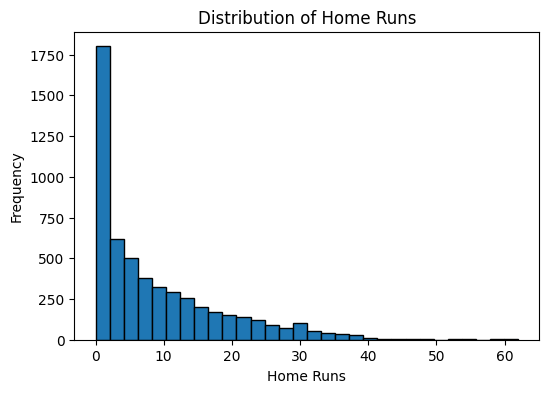

In [7]:
# distribution of target variable
plt.figure(figsize=(6,4))
plt.hist(df["home_run"], bins=30, edgecolor="black")
plt.xlabel("Home Runs")
plt.ylabel("Frequency")
plt.title("Distribution of Home Runs")
plt.show()

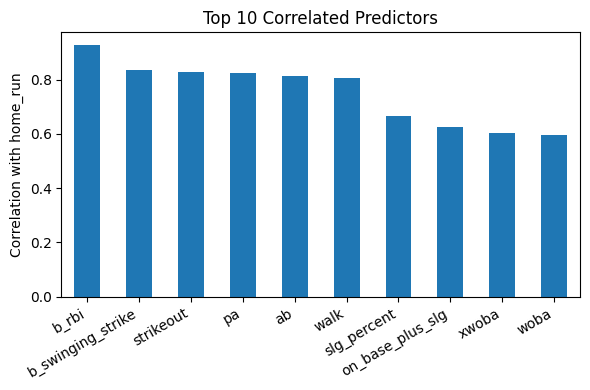

In [8]:
# top 10 correlations with home_run
corrs = df.corr(numeric_only=True)["home_run"].drop("home_run").sort_values(key=abs, ascending=False)
top10 = corrs.head(10)

plt.figure(figsize=(6,4))
top10.plot(kind="bar")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Correlation with home_run")
plt.title("Top 10 Correlated Predictors")
plt.tight_layout()
plt.show()

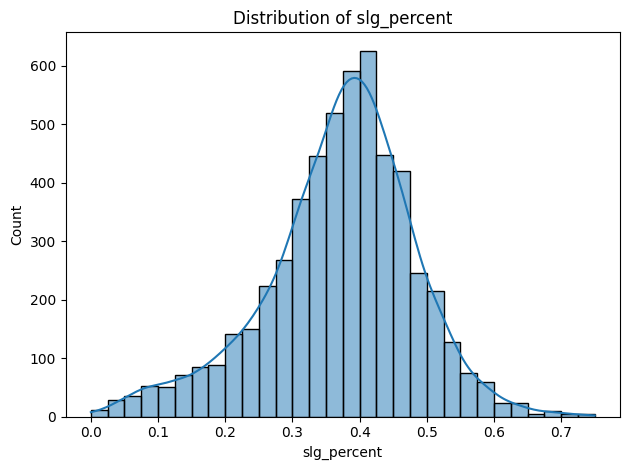

In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure()
sns.histplot(df['slg_percent'].dropna(), kde=True, bins=30)
plt.title(f"Distribution of {'slg_percent'}")
plt.xlabel('slg_percent')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

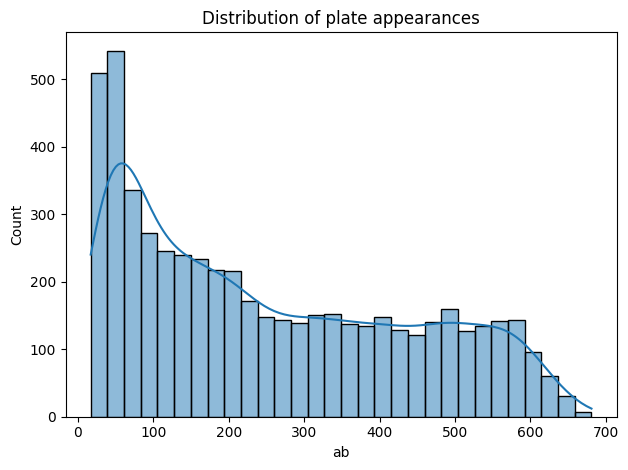

In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure()
sns.histplot(df['ab'].dropna(), kde=True, bins=30)
plt.title(f"Distribution of {'plate appearances'}")
plt.xlabel('ab')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [11]:
# Filtering out rows where 'ab' (plate appearances) is less than or equal to 100
df = df[df['ab'] > 100]

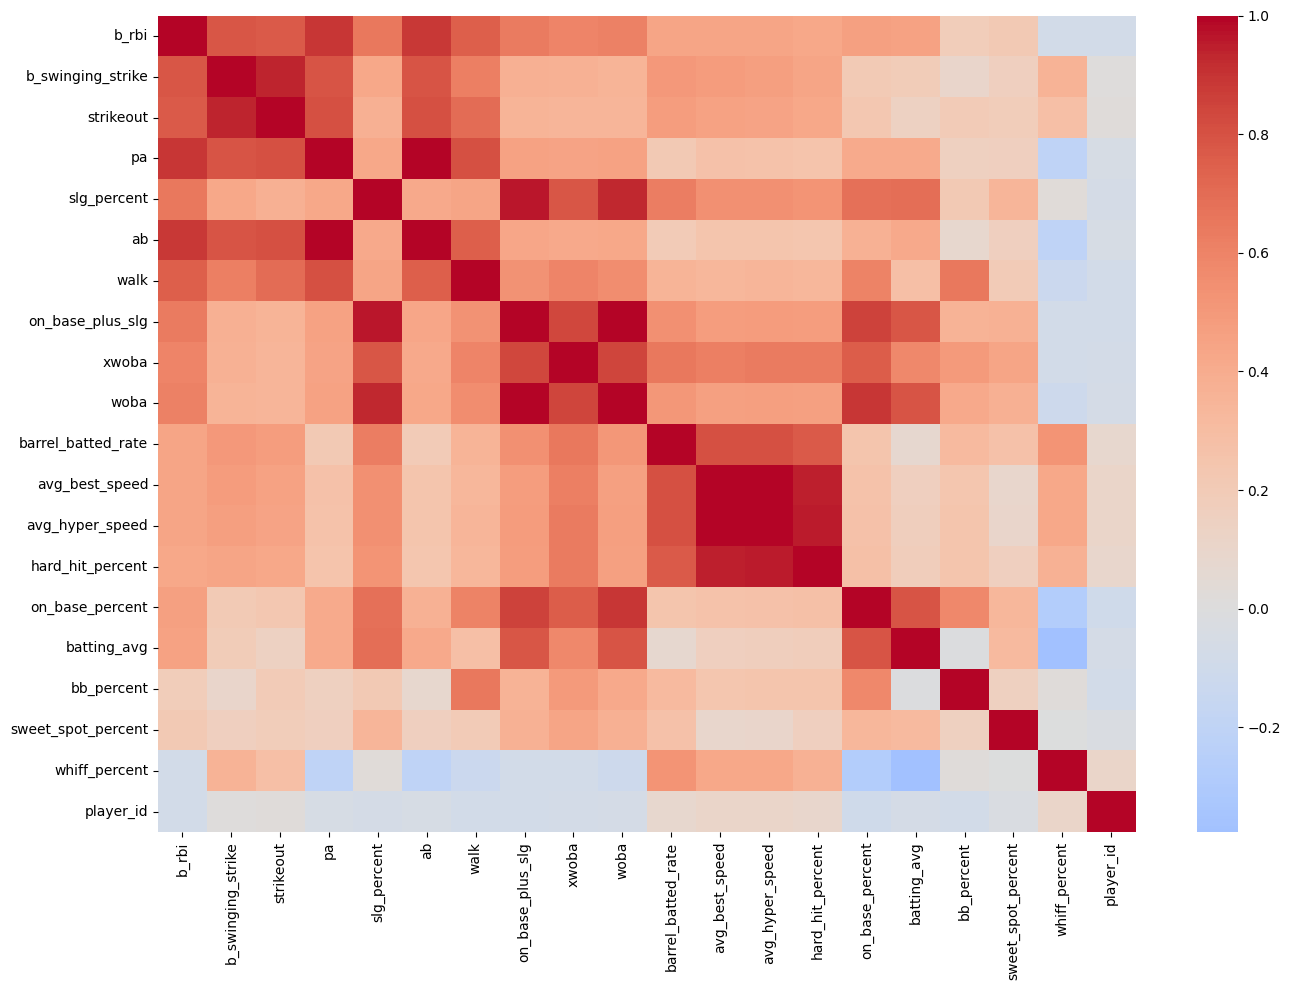

In [12]:
target = "home_run"
corr = df[numeric_cols].corr()
top20 = corr[target].abs().sort_values(ascending=False).index[1:21]
corr_top20 = corr.loc[top20, top20]
plt.figure(figsize=(14, 10))
sns.heatmap(corr_top20, annot=False, cmap="coolwarm", center=0)
plt.tight_layout()
plt.show()

In [13]:
# remove non-numeric columns
id_cols = [col for col in df.columns if 'name' in col.lower() or 'id' in col.lower()]
df = df.drop(columns=id_cols, errors='ignore')

y = df['home_run']
X = df.drop(columns=['home_run'])

# split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (3048, 22)
Test shape: (763, 22)


# **Random Forest**

### Model Variant 1: Baseline model

In [ ]:
rf_v1 = RandomForestRegressor(n_estimators=100, max_depth=None, max_features="sqrt", min_samples_split=2, min_samples_leaf=1, random_state=42, n_jobs=-1)
rf_v1.fit(X_train, y_train)
y_train_pred = rf_v1.predict(X_train)
y_test_pred  = rf_v1.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test,  y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test,  y_test_pred)
metrics = pd.DataFrame({"Train": [train_r2, train_rmse, train_mae], "Test":  [test_r2,  test_rmse,  test_mae]}, index=["R²", "RMSE", "MAE"])
print(f"\n{rf_v1} – Train/Test metrics")
print(metrics)
cv_r2_v1 = cross_val_score(rf_v1, X_train, y_train, cv=5, scoring="r2")
cv_mse_v1 = -cross_val_score(rf_v1, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
cv_rmse_v1 = np.sqrt(cv_mse_v1)
cv_mae_v1 = -cross_val_score(rf_v1, X_train, y_train, cv=5,scoring="neg_mean_absolute_error")
print("\nCV Summary (Variant 1):")
print(f"Mean R²:   {cv_r2_v1.mean():.4f}")
print(f"Mean RMSE: {cv_rmse_v1.mean():.4f}")
print(f"Mean MAE:  {cv_mae_v1.mean():.4f}")


RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42) – Train/Test metrics
         Train      Test
R²    0.991179  0.937403
RMSE  0.923622  2.352520
MAE   0.678852  1.729712

CV Summary (Variant 1):
Mean R²:   0.9345
Mean RMSE: 2.5129
Mean MAE:  1.8559


### Model Variant 2: Only using top 10 most correlated features

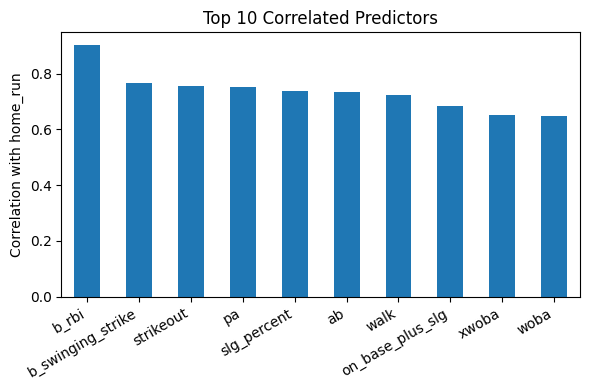

In [ ]:
corrs = df.corr(numeric_only=True)["home_run"].drop("home_run").sort_values(key=abs, ascending=False)
top10 = corrs.head(10)
top10_features = corrs.abs().sort_values(ascending=False).head(10).index.tolist()
plt.figure(figsize=(6,4))
top10.plot(kind="bar")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Correlation with home_run")
plt.title("Top 10 Correlated Predictors")
plt.tight_layout()
plt.show()

In [ ]:
X_train_top10 = X_train[top10_features]
X_test_top10  = X_test[top10_features]
rf_v2 = RandomForestRegressor(n_estimators=100, max_depth=None, max_features="sqrt", random_state=42,n_jobs=-1)
rf_v2.fit(X_train_top10, y_train)
y_train_pred = rf_v2.predict(X_train_top10)
y_test_pred  = rf_v2.predict(X_test_top10)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test,  y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test,  y_test_pred)
metrics = pd.DataFrame({"Train": [train_r2, train_rmse, train_mae], "Test":  [test_r2,  test_rmse,  test_mae]}, index=["R²", "RMSE", "MAE"])
print("\nRandomForestRegressor Variant 2 – Train/Test metrics")
display(metrics)
cv_r2_v2 = cross_val_score(rf_v2, X_train_top10, y_train, cv=5, scoring="r2")
cv_mse_v2 = -cross_val_score( rf_v2, X_train_top10, y_train, cv=5, scoring="neg_mean_squared_error")
cv_rmse_v2 = np.sqrt(cv_mse_v2)
cv_mae_v2 = -cross_val_score(rf_v2, X_train_top10, y_train,cv=5, scoring="neg_mean_absolute_error")
cv_results_v2 = pd.DataFrame({
    "Fold": [1, 2, 3, 4, 5],
    "R²":   cv_r2_v2,
    "RMSE": cv_rmse_v2,
    "MAE":  cv_mae_v2
})
print("\nCV Summary (Variant 2):")
print(f"Mean R²:   {cv_r2_v2.mean():.4f}")
print(f"Mean RMSE: {cv_rmse_v2.mean():.4f}")
print(f"Mean MAE:  {cv_mae_v2.mean():.4f}")


RandomForestRegressor Variant 2 – Train/Test metrics


,Train,Test
R²,0.988946,0.920964
RMSE,1.033939,2.643438
MAE,0.770259,1.980079



CV Summary (Variant 2):
Mean R²:   0.9199
Mean RMSE: 2.7795
Mean MAE:  2.0775


In [ ]:
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid_v3 = {
    "n_estimators": [100, 300, 500],           # number of trees
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],  # pruning strength
    "max_depth": [None, 5, 10, 20],            # tree depth (use 10 instead of 1e0)
    "max_features": ["sqrt", "log2", None]     # num features per split
}
rf_grid_v3 = GridSearchCV( estimator=rf_base, param_grid=param_grid_v3, scoring="neg_mean_squared_error", cv=5,n_jobs=-1)
rf_grid_v3.fit(X_train, y_train)
print("Best hyperparameters for Random Forest Variant 3:")
print(rf_grid_v3.best_params_)
best_rf_v3 = rf_grid_v3.best_estimator_
y_train_pred = best_rf_v3.predict(X_train)
y_test_pred  = best_rf_v3.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test,  y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test,  y_test_pred)
metrics_v3 = pd.DataFrame({
    "Train": [train_r2, train_rmse, train_mae],
    "Test":  [test_r2,  test_rmse,  test_mae]
}, index=["R²", "RMSE", "MAE"])
print("\nRandom Forest Variant 3 – Tuned Model Train/Test Metrics")
display(metrics_v3)
cv_r2_v3 = cross_val_score(best_rf_v3, X_train, y_train,cv=5, scoring="r2")
cv_mse_v3 = -cross_val_score(
    best_rf_v3, X_train, y_train,
    cv=5, scoring="neg_mean_squared_error"
)
cv_rmse_v3 = np.sqrt(cv_mse_v3)
cv_mae_v3 = -cross_val_score(
    best_rf_v3, X_train, y_train,
    cv=5, scoring="neg_mean_absolute_error"
)
cv_results_v3 = pd.DataFrame({
    "Fold": [1, 2, 3, 4, 5],
    "R²":   cv_r2_v3,
    "RMSE": cv_rmse_v3,
    "MAE":  cv_mae_v3
})
print("\nRandom Forest Variant 3 – 5-Fold Cross-Validation Results")
print("\nCV Summary (Variant 3):")
print(f"Mean R²:   {cv_r2_v3.mean():.4f}")
print(f"Mean RMSE: {cv_rmse_v3.mean():.4f}")
print(f"Mean MAE:  {cv_mae_v3.mean():.4f}")


Best hyperparameters for Random Forest Variant 3:
{'ccp_alpha': 0.0, 'max_depth': None, 'max_features': None, 'n_estimators': 500}

Random Forest Variant 3 – Tuned Model Train/Test Metrics


,Train,Test
R²,0.992578,0.946086
RMSE,0.847217,2.183265
MAE,0.632579,1.626949



Random Forest Variant 3 – 5-Fold Cross-Validation Results

CV Summary (Variant 3):
Mean R²:   0.9428
Mean RMSE: 2.3480
Mean MAE:  1.7533


In [42]:
y_test_pred_v3 = best_rf_v3.predict(X_test)
test_rmse_v3 = np.sqrt(mean_squared_error(y_test, y_test_pred_v3))
test_mae_v3 = mean_absolute_error(y_test, y_test_pred_v3)
test_r2_v3 = r2_score(y_test, y_test_pred_v3)

print("\nTest Set Performance (Variant 3):")
print(f"R²:   {test_r2_v3:.4f}")
print(f"RMSE: {test_rmse_v3:.4f}")
print(f"MAE:  {test_mae_v3:.4f}")



Test Set Performance (Variant 3):
R²:   0.9461
RMSE: 2.1833
MAE:  1.6269


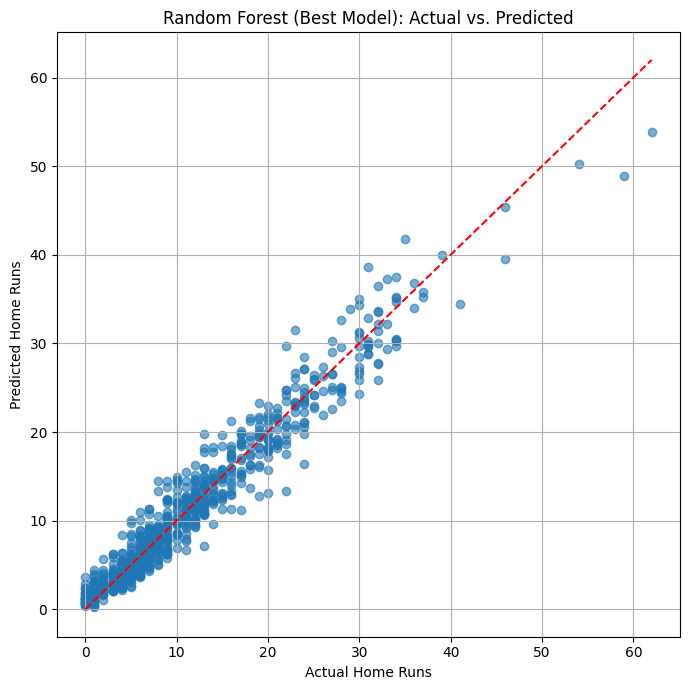

In [43]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_test_pred, alpha=0.6)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Actual Home Runs")
plt.ylabel("Predicted Home Runs")
plt.title("Random Forest (Best Model): Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

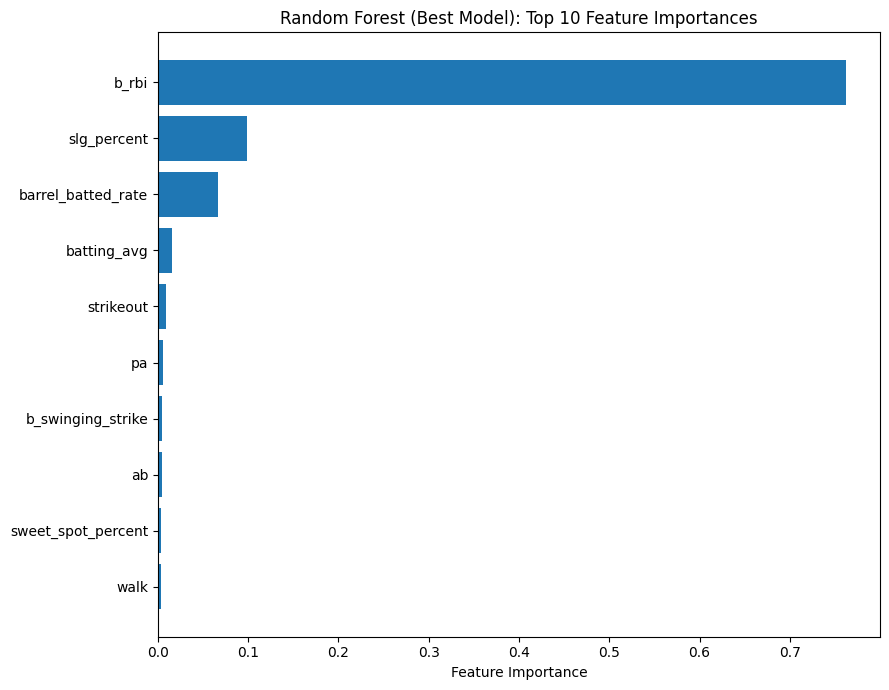

In [44]:
importances = best_rf_v3.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(9,7))
plt.barh(X_train.columns[sorted_idx][-10:], importances[sorted_idx][-10:])
plt.xlabel("Feature Importance")
plt.title("Random Forest (Best Model): Top 10 Feature Importances")
plt.tight_layout()
plt.show()